#ΜΕΡΟΣ 2

In [ ]:
!ls -lh

total 4.0K
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data


In [ ]:
!dir

sample_data


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#καλω τα παρακάτω για να τυπώσω μετά τις ταινίες (γιατί τα data δεν ειναι μεσα στο corpus)

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 82

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

##Δημιουργία Dataset

In [ ]:
#corpus

In [ ]:
import re

def delurl(a):
 text = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", " ", a)
 return text

Corpus = []
for i in corpus: 
    Corpus.append(delurl(i))

import string
import re

#erase '_' cause tokenizer can't 

for substring in Corpus: 
     re.sub('_' , ' ' , substring)

import nltk
from nltk.tokenize import word_tokenize
#print(type(corpus))

nltk.download('punkt') # χρειάζεται για το tokenizer


Corpus2 = []
for i in Corpus:
  Corpus2.append(i.lower())

Corpus3=[]
for i in Corpus2:
 Corpus3.append(nltk.wordpunct_tokenize(i))  

nltk.download('stopwords') 
nltk.download('punkt')
from nltk.corpus import stopwords
import string

filtered_words=[]
for sublist in Corpus3:
  filtered_words.append([word for word in sublist if word not in stopwords.words('english') + list(string.punctuation)])     

filtered_words2 = []

for sublist in filtered_words: 
  filtered_words2.append([word for word in sublist if (len(word) >2 ) ]) 

filtered_words3 = []
search2 = string.punctuation

for sublist in filtered_words2: 
  filtered_words3.append([word for word in sublist if (word[0] or word[1] or word[2]) not in search2 ])  

filtered_words4 = []
search2 = string.punctuation

for sublist in filtered_words3: 
  filtered_words4.append([word for word in sublist if not (word.isdigit()) ])  

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

stemmed_words = []
for sublist in filtered_words4:
    stemmed_words.append([porter_stemmer.stem(word) for word in sublist])

document=[]
for sublist in stemmed_words:
      document.append(' '.join(word for word in sublist))

print(document)         

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import joblib
joblib.dump(document, 'doc.pkl')
document = joblib.load('doc.pkl')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.4, min_df=200)
vectorizer.fit(document)
corpus_tf_idf = vectorizer.transform(document)
print(corpus_tf_idf.shape)

(5000, 567)


In [ ]:
idxs_nonzero = np.nonzero(catbins.sum(axis=0))[0]
print(f'{len(idxs_nonzero)} \ {catbins.shape[1]} are nonzero -> {catbins.shape[1] - len(idxs_nonzero)} dims are useless')
catbins_nonzero = catbins[:, idxs_nonzero]

263 \ 322 are nonzero -> 59 dims are useless


In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins_nonzero[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(corpus_tf_idf)

In [ ]:
final_set.shape

(5000, 830)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_set_opt = scaler.fit_transform(final_set)
final_set_opt.min(), final_set_opt.max()

(0.0, 1.0)

πολλές διαστάσεις , θέλουμε μείωση , γιατί δεν θα τρέξει το somoclu.

##Εκπαίδευση χάρτη SOM


In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 31.8 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481128 sha256=69ec6767470be767b610c4c4bec2b713b8f2c01922a343b34782bd0d788b463d
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


In [ ]:
n_rows1, n_columns1 = 10, 10
n_epochs1 = 100
som1 = somoclu.Somoclu(n_columns1, n_rows1, compactsupport=False, maptype='planar', verbose=1)
%time som1.train(final_set_opt, epochs=n_epochs1)

CPU times: user 2min 28s, sys: 677 ms, total: 2min 28s
Wall time: 1min 32s


In [ ]:
n_rows2, n_columns2 = 16, 16
n_epochs2 = 100
som2 = somoclu.Somoclu(n_columns2, n_rows2, compactsupport=False, maptype='planar', verbose=1)
%time som2.train(final_set_opt, epochs=n_epochs2)

CPU times: user 6min 28s, sys: 1.99 s, total: 6min 30s
Wall time: 3min 41s


In [ ]:
n_rows3, n_columns3 = 25 , 25
n_epochs3 = 100
som3 = somoclu.Somoclu(n_columns3, n_rows3, compactsupport=False, maptype='planar', verbose=1)
%time som3.train(final_set_opt, epochs=n_epochs2)

CPU times: user 15min 53s, sys: 4.38 s, total: 15min 57s
Wall time: 8min 12s



##Best matching units

Μετά την εκπαίδευση αποθηκεύουμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της np.unique αποθηκεύουμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Μπορεί να υπάρχουν λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες.


In [ ]:
#10x10
bmus1 = som1.bmus
ubmus1, indices1 = np.unique(bmus1, return_inverse=True, axis=0)
print(f'Number of unique bmus: {len(ubmus1)}')
#aptous 100

Number of unique bmus: 100


In [ ]:
indices1.shape

(5000,)

In [ ]:
#print(ubmus1)

In [ ]:
#print(indices1)

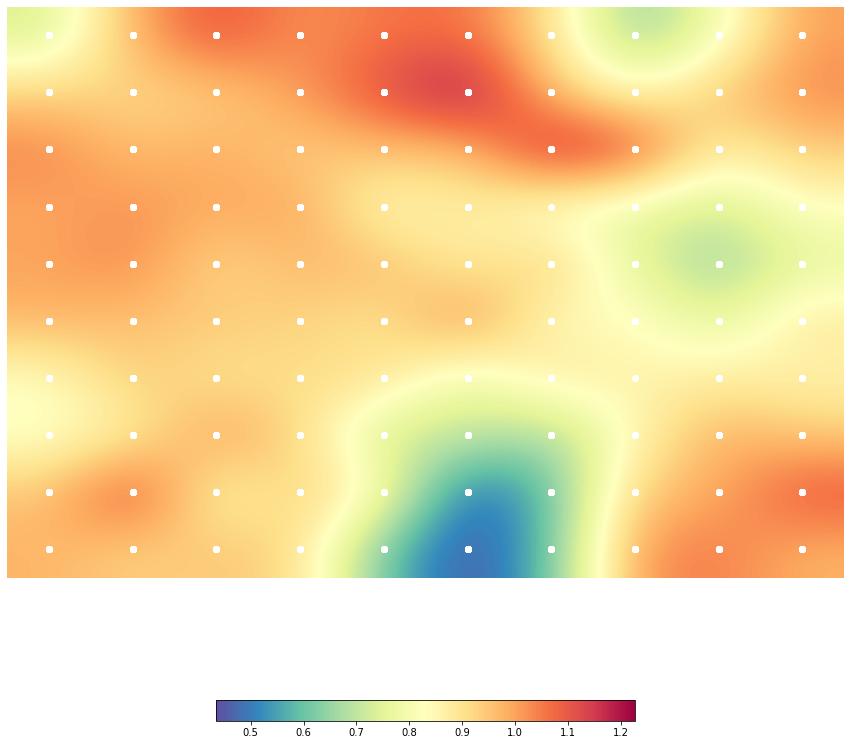

In [ ]:
som1.view_umatrix(colorbar=True, bestmatches = True, figsize=(15, 15));

Παρατηρούμε ότι υπάρχουν πολλές κόκκινες περιοχές και η μέση απόστασή από τους γειτονικούς κόμβους είναι πολύ μεγάλη. Επομένως θέλουμε πλέγμα μεγαλύτερου μεγέθους, να προσθέσουμε δηλαδή περισσότεους νευρώνες (16x16 , 25x25) .



In [ ]:
#16x16 (256)
bmus2 = som2.bmus
ubmus2, indices2 = np.unique(bmus2, return_inverse=True, axis=0)
print(f'Number of unique bmus: {len(ubmus2)}')

Number of unique bmus: 229


In [ ]:
#25x25 (625)
bmus3 = som3.bmus
ubmus3, indices3 = np.unique(bmus3, return_inverse=True, axis=0)
print(f'Number of unique bmus: {len(ubmus3)}')

Number of unique bmus: 528


##Ομαδοποίηση (clustering), Οπτικοποίηση U-matrix και μέγεθος clusters
Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τους χάρτες χρησιμοποιούμε        k= 25 , 30 , 35. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

Δημιουργούμε την παρακάτω συνάρτηση για να τυπώνουμε τον αριθμό του cluster που αντιστοιχεί στον κάθε νευρώνα, τις συχνότητες των clusters με αύξουσα σειρά και το U-matrix. Η συνάρτηση καλείται για διαστάσεις νευρώνων στο SOM (10x10, 16x16 , 25x25) και αριθμό clusters στο Kmeans (25, 30 , 35).

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans

def print_kmeans(som, n_clusters, n_neurons):

    print('\n')
    print('####################################')
    print(f'n_neurons: {n_neurons}X{n_neurons}, n_clusters: {n_clusters}')
    print('####################################\n')
    
    algorithm = KMeans(n_clusters=n_clusters)
    som.cluster(algorithm=algorithm)
    clusters = som.clusters
    counter = Counter(clusters.ravel())
    clusters_sorted, freqs_sorted = zip(*counter.most_common()[::-1])
   
    print(clusters)
    print('\n\nClusters sorted by increasing number of neurons')
    print('Cluster index')
    print('Number of neurons')
    print(clusters_sorted)
    print(freqs_sorted)
    print('\n\n')

    som.view_umatrix(bestmatches=True, figsize=(15, 15), colorbar=True)



####################################
n_neurons: 10X10, n_clusters: 25
####################################

[[13 13  4  9  9 15 11 11 11  7]
 [13 13  4  9 15 15 11 11 20 20]
 [24 24  4  4 14 14 12 12  1  1]
 [24 18 18 14 14 14  5  1  1  1]
 [24  2  2 19 14  5  5  1  1  1]
 [ 0  2 19 19 17  5  5  1  1 22]
 [ 0  0 19 17 17 17  3  3 23 22]
 [ 0  6  6  6 17  8  8  3 23 23]
 [16 16  6 21 21  8  8  8 10 10]
 [16 16  6 21 21  8  8  8 10 10]]


Clusters sorted by increasing number of neurons
Cluster index
Number of neurons
(7, 22, 18, 12, 20, 23, 3, 2, 15, 9, 10, 21, 16, 0, 19, 24, 4, 13, 6, 17, 5, 11, 14, 8, 1)
(1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 8, 10)





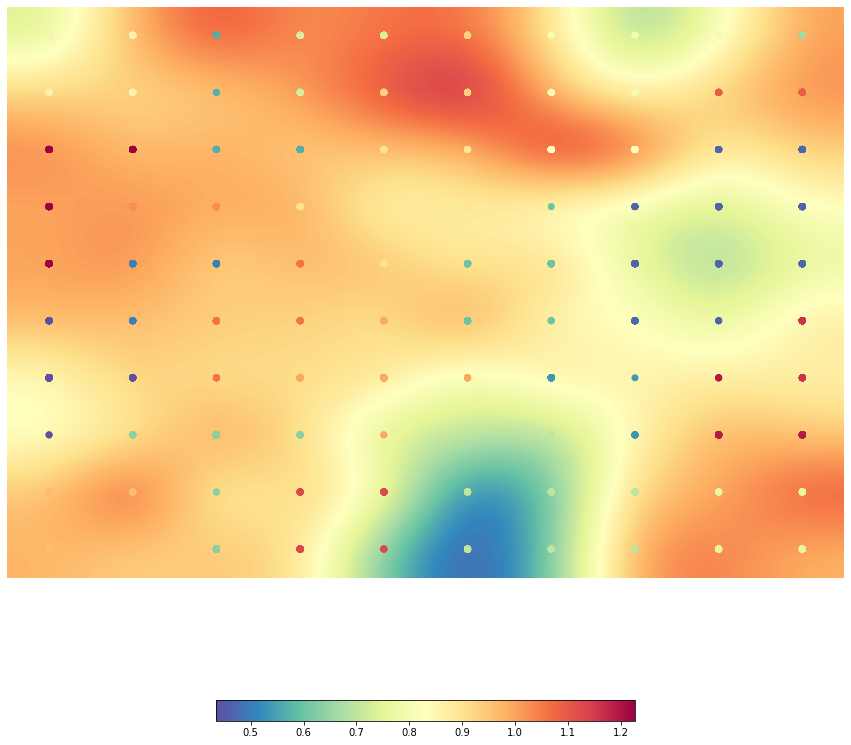



####################################
n_neurons: 10X10, n_clusters: 35
####################################

[[13 13 20 19 19 10 34 34  1  1]
 [13  8 29 19 25 10 34 34 27 27]
 [ 8  8 29  3 25  7 24 24 21 21]
 [16 16 29  3 26  7  7  6 28 28]
 [33 23 23 26 26  7  7  6 28 28]
 [31 23  4  4 26 15 15 28 28 17]
 [12 12 11 18 18 18  2  2  9 17]
 [12 11 11 11 18  2  2  2  9  9]
 [ 5  5 11 14  2  2  2 22 30 30]
 [32 32 14 14  2  2  2 22  0  0]]


Clusters sorted by increasing number of neurons
Cluster index
Number of neurons
(31, 33, 20, 0, 32, 30, 22, 5, 17, 15, 4, 6, 16, 21, 24, 3, 27, 25, 1, 10, 14, 9, 12, 23, 29, 8, 19, 13, 18, 26, 34, 11, 7, 28, 2)
(1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 11)





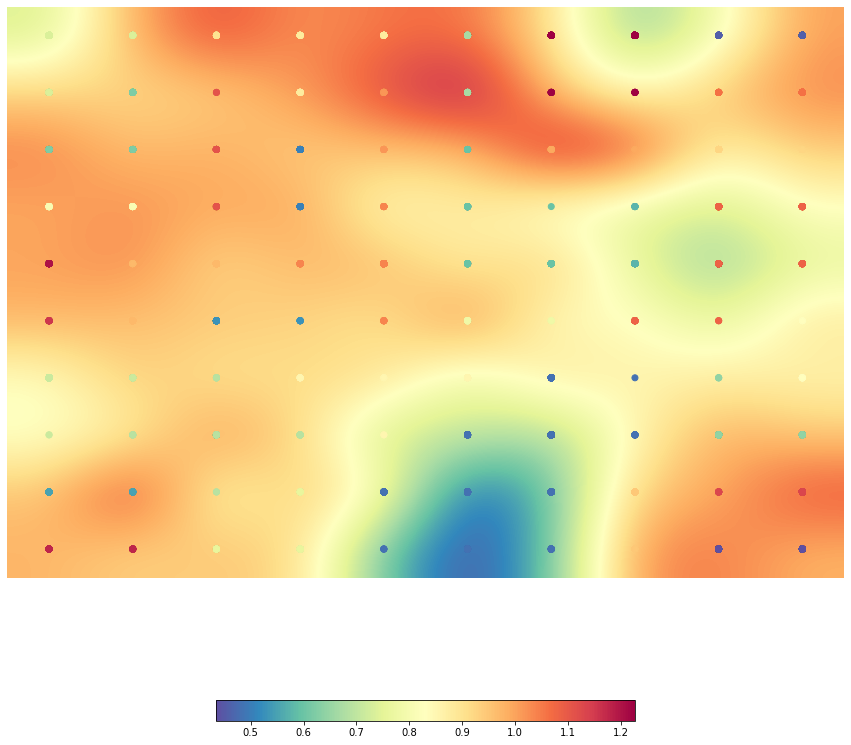



####################################
n_neurons: 10X10, n_clusters: 30
####################################

[[19 19 25 21  6 27  8  8  8 28]
 [19  4 25 21 16 16  8  8 18 18]
 [ 4  4  4 21 16  3 13 13 29 29]
 [11 11 11 24  3  3  3  0  0  0]
 [26 20 20 24 24  3 15  0  0  0]
 [26 20  2  2 17 15 15  0  0  0]
 [ 1  1  2 17 17 17 10 10 22 22]
 [ 1 12 12 12 17 14 14 14 22 22]
 [ 9  9 12  5  5 14 14 23  7  7]
 [ 9  9 12  5 14 14 14 23  7  7]]


Clusters sorted by increasing number of neurons
Cluster index
Number of neurons
(28, 27, 6, 23, 10, 26, 29, 13, 18, 25, 5, 1, 2, 15, 20, 24, 11, 16, 21, 19, 7, 9, 22, 4, 12, 17, 3, 8, 14, 0)
(1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 8, 9)





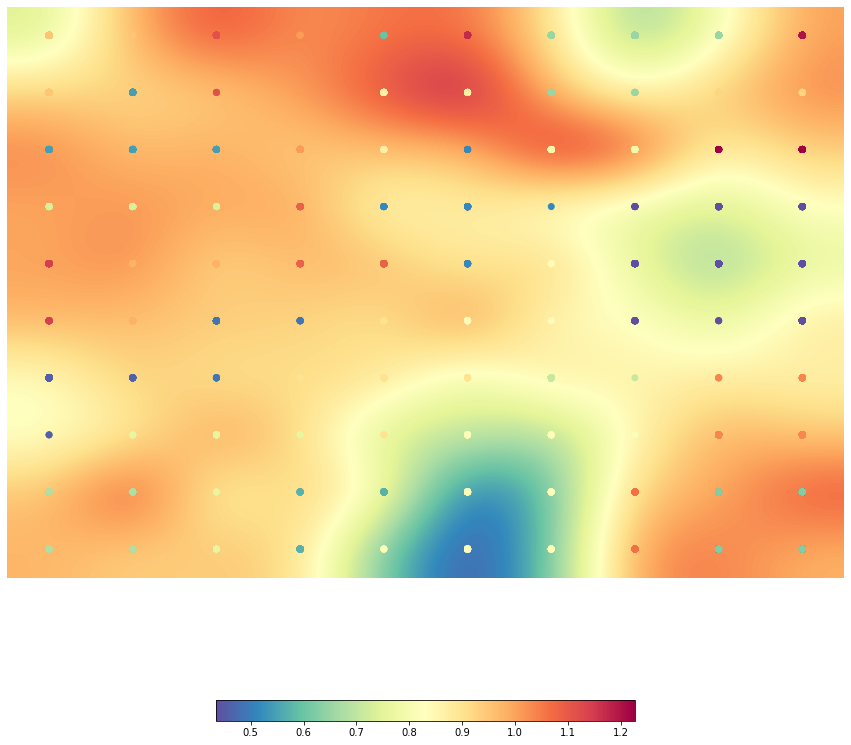



####################################
n_neurons: 16X16, n_clusters: 25
####################################

[[13 13  3 12 12 12 12 12 14 14 14 14 14  8  8  8]
 [13 13  3  3 12 12 12 12 14 14 14 14 14  8  8  8]
 [13 13  9  3 12 12 12 12 12 14 14 14 14  0  8  8]
 [ 9  9  9  9 18 18 12 12 24  6 14 14  0  0  0  0]
 [ 9  9  9 18 18 18 18  6  6  6  6  6 22 22 22  0]
 [ 1  9 23  1 18 18  6  6  6  6  6  6 22 22 16 16]
 [24 24  1  1  1  1  2  6  2  6  6  6  6 16 16 16]
 [24 24  1  1  1  1  2  2  2  2  6  6  6  5  5  5]
 [24 24  1  1  1  1  1  2  2  6  6  6  5  5  5  5]
 [ 1  1  1  1  1  1  1  1 21 21 21  6  6  5 20 20]
 [23 23  1  1  1  1  1 21 21 21 21 21  6 20 20 20]
 [23 23 23  1  1  1  1  6 21 21 21  7  7  7 20 20]
 [23 23 11 11 11  1  4  4  4  4 15  7  7  7  7 17]
 [10 10 11 11 11 11  4  4  4  4 15 15  7  7 17 17]
 [10 19 19 19 11 11  6  4  4  4 15 15 15  7 17 17]
 [19 19 19 19 11 11  6  4  4  4 15 15 15 17 17 17]]


Clusters sorted by increasing number of neurons
Cluster index
Number of

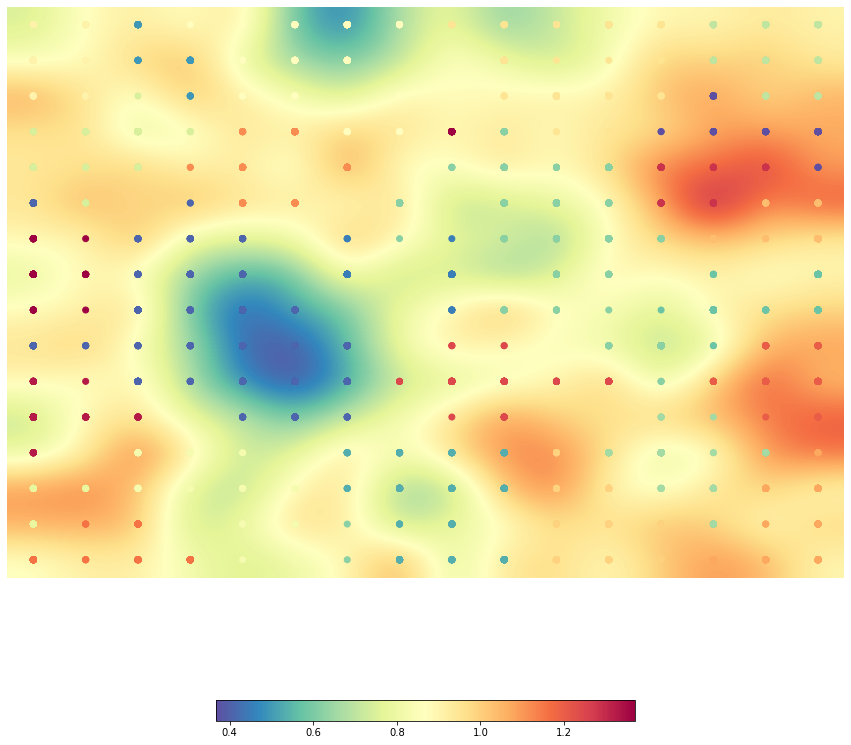



####################################
n_neurons: 16X16, n_clusters: 35
####################################

[[ 2  2  2 29 29 29 29 29 19 19 19 19 33 33 24 24]
 [ 2  2  2 29 29 29 29 29 19 19 19 19 33 30 24 24]
 [ 2  3  3  3 29 29 29 14 14 19 34 34 30 30  6  6]
 [ 3  3  3  3 15 15 15 14 14 14 34 34 34 30  6  6]
 [ 3  3  3  3 28 28 28  8 14  8  8 11 11 25 25 25]
 [27 27 27 28 28 28  8  8  8  8  8  8  8 25 25 25]
 [10 10 27 27 27 28  9  8 26  8  8  8  8  8  4  4]
 [10 10 27 27 27 12  9 26 26 26  8  8  8  4  4  4]
 [10 10 31 27 12 12 12 26 26  8  8  5  5  4  4  4]
 [27 31 31 12 12 12 12 12 23 23 23  5  5  5 22 22]
 [18 31 31 31 12 12 12 23 23 23 23  5  5  5 22 22]
 [18 18 31 31 12 12 12  1 23 23 23  5 13  5 22 22]
 [18 18 17 17 17 12  1  1  1 16 16 13 13 13 13  0]
 [18 18 17 17 17 17  1  1  1 16 16 21 13 13 13  0]
 [ 7  7 17 17 17 32 32  1 20 20 21 21 21 13  0  0]
 [ 7  7 17 17 17 32 32 20 20 20 20 21 21 13  0  0]]


Clusters sorted by increasing number of neurons
Cluster index
Number of

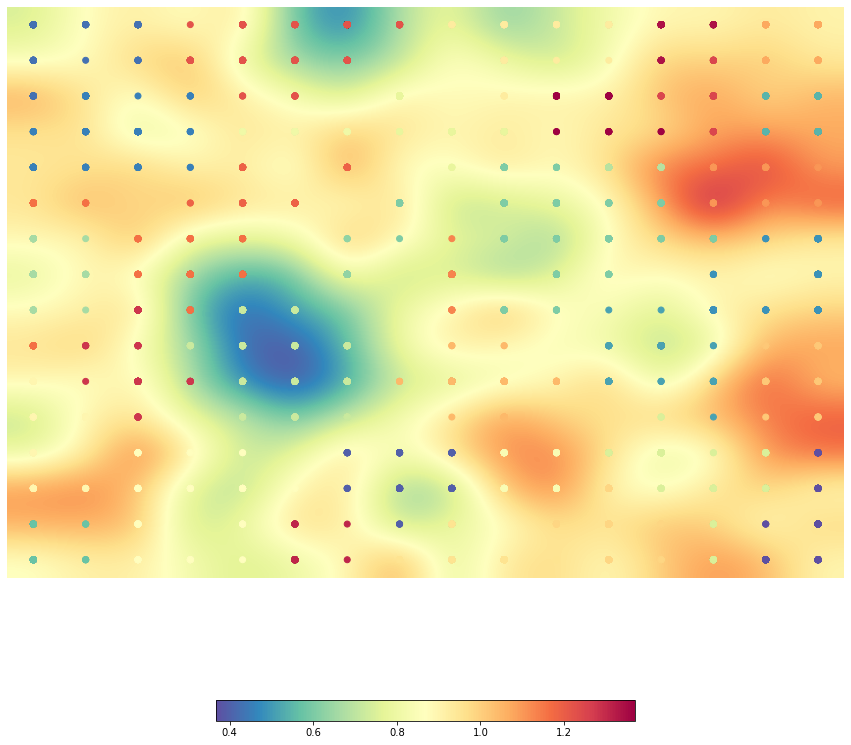



####################################
n_neurons: 16X16, n_clusters: 30
####################################

[[ 8  8  8 23 23 23 23 23 17 17 17 17 12 12 12 12]
 [ 8  8  8 23 23 23 23 23 17 17 17 17 12 12 12 12]
 [ 8  8 11 11 23 23 23  4  4 17 16 16  5  5  5 22]
 [11 11 11 11 21 21 21  4  4  4 16 16 16  5 22 22]
 [11 11 11 11 21 21 19 14  4 14 14 16 15 15 22 22]
 [ 6  6 18  3  3  3 14 14 14 14 14 14 15 15 19 19]
 [26 26  6  6  3  3  1 14  1 14 14 14 15 14 19 19]
 [26 26  6  6  6  6  1  1  1  1 14 14 14  0 27 27]
 [26 26  6  6  6  6  6  1  1 14 14  0  0  0 27 27]
 [ 6  6  6  6  6  6  6  6  2  2  2  0  0  0 20 20]
 [18 18  6  6  6  6  6  2  2  2  2  2  0 29 29 20]
 [18 18 18  6  6  6  6 14  2  2  2  2 10 29 29 29]
 [18 18 18 25 25  6  9  9  9  9 24 10 10 10  7  7]
 [18 18 25 25 25 25  9  9  9  9 24 24 10 10 10  7]
 [28 28 13 13 25 25  9  9  9  9 24 24 24 10  7  7]
 [28 28 13 13 25 25  9  9  9  9 24 24 24  7  7  7]]


Clusters sorted by increasing number of neurons
Cluster index
Number of

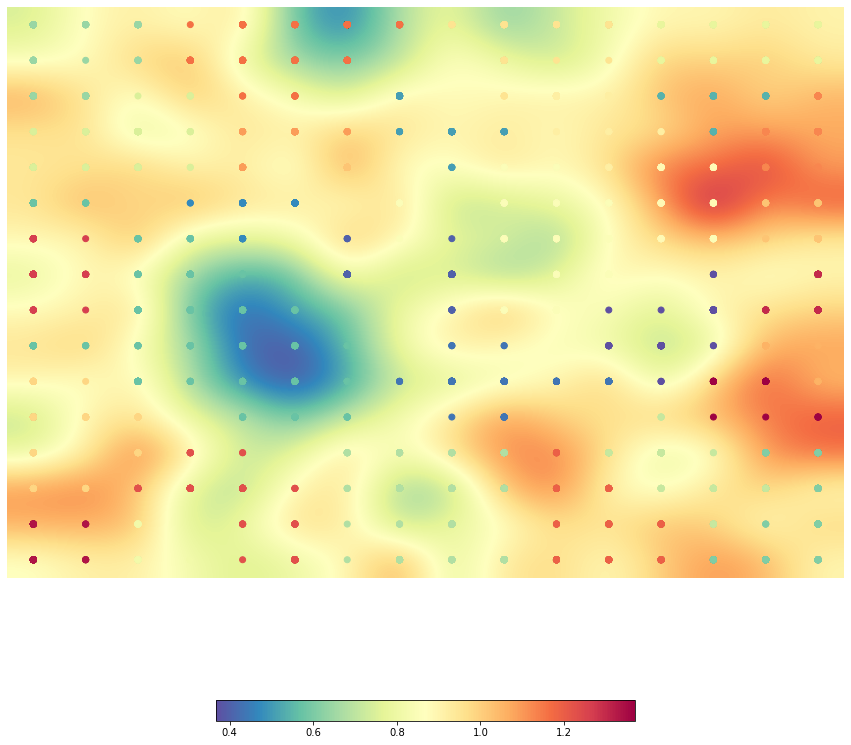



####################################
n_neurons: 25X25, n_clusters: 25
####################################

[[12 12 12 12 12  6  6  6 21 21 21 21 21  2  2  2  7  7 14 14 14 14 10 10
  10]
 [12 12 12 12 12  6  6  6 21 21 21 21  2  2  2  2  7  7 14 14 14 10 10 10
  10]
 [12 12 12 12  6  6  6  6  6 21 21 21  2  2  2  7  7  7 14 14 14 10 10 10
  10]
 [12 12 12 12  6  6  6  6  6  6 21  2  2  2  7  7  7  7 14 14 14 10 10 10
  10]
 [12 12 12 12  6  6  6  6  6  6  6 15 15 15  7  7  7 18 14 14 14 10 10 10
  10]
 [16 16 12 16  6  6  6  6  6  6 15 15 15 15 18 18 18 18 18 14 10 10 10 10
  10]
 [16 16 16 16 16  6  6  6  6 19 19 15 15 15 18 18 18 18 15 20 20 20 10 10
  10]
 [16 16 16 16 16 19 19 19 19 19 19 15 15 15  9 18 18 18 20 20 20 20 20 20
  10]
 [12 16 16 16 16 19 19 19 19 19 19 15 15  9  9  9 15 15 15 20 20 20 20 20
  20]
 [ 4 16 16 16 16 19 19 19 19 19 15 15 15  9  9  9 15 15 15 23 20 20 20 20
  17]
 [ 4  4 16 16 22 22 22 19 19 13 13 15 15  9  9  9 23 23 23 23 23 20 20 17
  17]
 [ 4  4  4

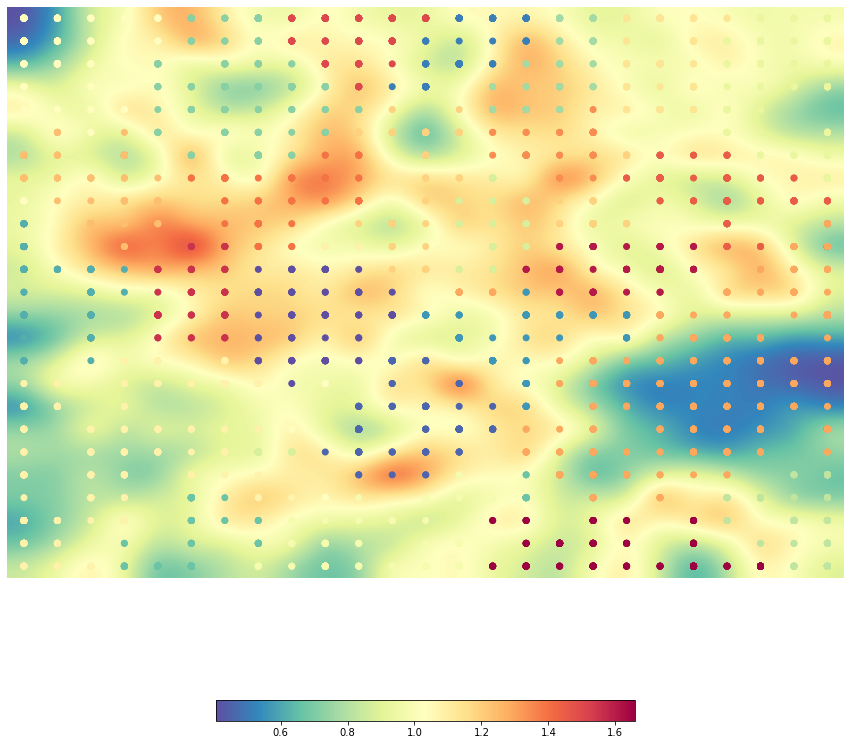



####################################
n_neurons: 25X25, n_clusters: 35
####################################

[[12 12 12 12 12  0  0 29 29 29 29 29 29 10 10 10  5  5  5  5  5 17 17 17
  17]
 [12 12 12 12  0  0 11 29 29 29 29 29 10 10 10 10  5  5  5  5  5 17 17 17
  17]
 [12 12 12  0  0  0 11 11 11 29 29 29 10 10 10 10  5  5  5  5  5 17 17 17
  17]
 [12 12 12 12  0 11 11 11 11 11 29 10 10 10 10 23  5  5  5  5  3  3 17 17
  17]
 [12 12 12 12  0 11 11 11 11 11 11 27 27 27 23 23 23 23  5  5  3  3  3  3
   3]
 [19 19 12 34 11 11 11 11 11 30 30 27 27 27 23 23 23 23 23  5  3  3  3  3
   3]
 [19 19 34 34 34 11 11 11 11 30 30 27 27 27 23 23 23 23 27 26 26 26  3  3
   3]
 [19 19 19 34 34 13 13 11 30 30 30 27 27 27  1 23 23 23 26 26 26 26 26  3
   3]
 [19 19 19 34 25 25  8  8 25 30 30 27 27 24 24 24 14 14 14 26 26 26 26 34
  34]
 [18 19 19 19 19  8  4  4 25 25 27 27 27 24 24 24 14 14 14 14 26 26 26 34
  34]
 [18 18 19 19 20 20  4  4 25 25 25 27 24 24 24 24 14 14 14 14 14 26 34 34
  34]
 [18 18 18

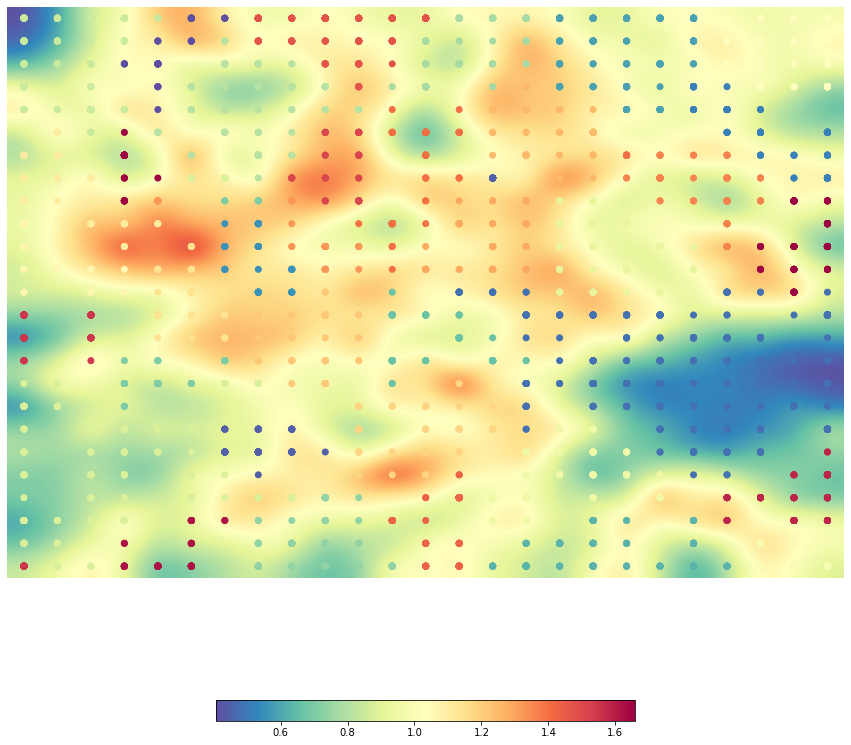



####################################
n_neurons: 25X25, n_clusters: 30
####################################

[[ 0  0  0  0  0 19 19 19 19  2  2  2  2  2  2  2 15 15 15 15 15 14 14 14
  14]
 [ 0  0  0  0  0 19 19 19 19  2  2  2  2  2  2  2 15 15 15 15 15 14 14 14
  14]
 [ 0  0  0  0 19 19 19 19 19 19  2  2  2  2  2  2 15 15 15 15 15 14 14 14
   2]
 [ 0  0  0  0 19 19 19 19 19 19  2  2  2  2  5  5  5 15 15 15 24 24 24 24
  24]
 [21 21 21 21 19 19 19 19 19 19 19 22 22 22  5  5  5 15 15 15 24 24 24 24
  24]
 [21 21 21 21 21 19 19  4  4  4 22 22 22 22  5  5 13 13 15 15 24 24 24 24
  24]
 [21 21 21 21 21  4  4  4  4  4 22 22 22 22 13 13 13 13 10 10 10 10 24 24
  24]
 [21 21 21 21 21  4  4  4  4  4 22 22 22 13 13 13 13 10 10 10 10 10 10 24
  24]
 [ 0  0 16 16 21 21  4  4  4 29 29 29 29 13 13 13 22 22 22 10 10 10 10 28
  28]
 [20 16 16 16 16 18 18 18 29 29 29 29 29 23 23 23 22 22 22  8 10 10 10 28
  28]
 [20 20 16 16 16 18 18 18 18 29 29 29 29 23 23 23 23 22  1  1  1 10 28 28
  28]
 [20 20 20

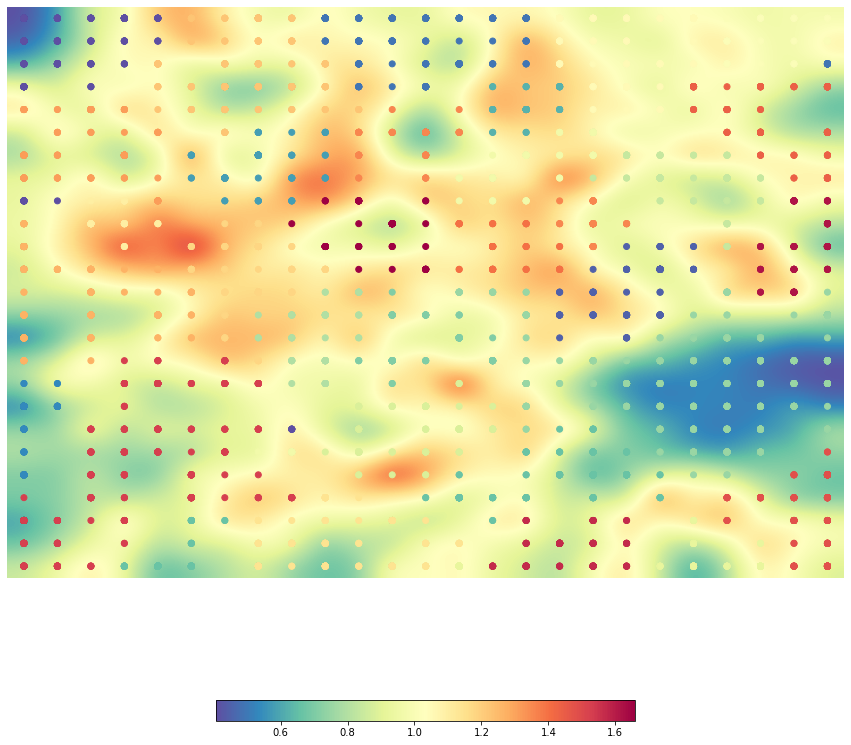

In [ ]:
for som, n_neurons in zip([som1, som2, som3], [n_rows1, n_rows2, n_rows3]):
    for n_clusters in {25, 30, 35}:
        print_kmeans(som, n_clusters, n_neurons)

##Αποθήκευση του SOM

In [ ]:
import joblib
joblib.dump(som1, 'som_10_10.pkl')
joblib.dump(som2, 'som_16_16.pkl')
joblib.dump(som3, 'som_25_25.pkl')

['som_25_25.pkl']

##Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.


Υλοποιούμε τις τρεις συναρτήσεις με βάση τις οδηγίες:

In [ ]:
def print_categories_stats(ids, categories):
  total_cat = []
  for id in ids:  
      category = categories[id][0]
      category = category.split('"')
      category = filter(lambda a: a != '', category)
      category = filter(lambda a: a != ',  ', category)
      total_cat.extend(category)

  labels, counts = np.unique(total_cat, return_counts = True)  
  categories_sorted = np.argsort(counts)
  categories_sorted = reversed(categories_sorted)
  sum = 0
  for c in counts:
    sum = sum+c
  total_sum = sum

  i=0;
  print('{:<40} {:<40} {:<40}'.format('Category', 'Number', 'Percentage'))
  for categories in categories_sorted:
      if(i<5):
        print('{:<40} {:<40} {:<40}'.format(labels[categories], str(counts[categories]), str(round(counts[categories]*100.0/total_sum,2))+'%'))
        i+=1;

In [ ]:
def print_cluster_neurons_movies_report(clusters,clust,ubmus):
  column, row = np.where(clusters == clust)
  arr = np.column_stack((row, column))
  
  bmus_cluster = []
  for bmu in arr:
    if bmu in ubmus:
      bmus_cluster.append(bmu)

  return bmus_cluster

In [ ]:
def neurons_movies_report(neurons,bmus, indices):
  ind_neuron = []
  for ind in range(len(bmus)):
    for neuron in neurons:
      if (bmus[ind]==neuron). all():
        ind_neuron.append(ind)

  ids = []
  for i in range(len(indices)):
    if indices[i] in ind_neuron:
      ids.append(i)
  
  print_categories_stats(ids, categories)    

για αρχή επιλέγω 20 clusters 

In [ ]:
som1 = joblib.load('som_10_10.pkl')

In [ ]:
som1.cluster(algorithm = KMeans(n_clusters = 20))
clusters1 = som1.clusters    #10x10
for i in range(20):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters1,i, ubmus1), ubmus1 , indices1)
  print('\n')

For cluster 0:
Category                                 Number                                   Percentage                              
Horror                                   344                                      30.55%                                  
Science Fiction                          63                                       5.6%                                    
Thriller                                 55                                       4.88%                                   
Slasher                                  53                                       4.71%                                   
Comedy                                   44                                       3.91%                                   


For cluster 1:
Category                                 Number                                   Percentage                              
Romance Film                             144                                      28.57%                   

Παρατηρουμε ότι έχει γίνει ένας μέτριος διαχωρισμός των ταινιών σε clusters οπότε παρακάτω βελτιστοποιούμε το SOM.

//
Σε κάθε cluster υπάρχει κυρίαρχη κατηγορία/κατηγορίες διαφορετική από τα υπόλοιπα. Συνεπώς η διαδικασία clustering έχει καλή συνοχή και εξειδίκευση.

Εύκολα διακρίνουμε πως κάθε cluster πάλι αντιστοιχεί σε ευδιάκριτη και ξεχωριστή θεματική ενότητα. Αυξάνοντας τον αριθμό των clusters προκύπτουν περισσότερες και πιο πλούσιες οικογένειες κατηγοριών.
//

**Βελτιστοποίηση SOM**

αυξάνουμε λοιπόν τις διαστάσεις του πλέγματος, όπως τονίσαμε πριν.

για SOM 16x16 :

In [ ]:
som2 = joblib.load('som_16_16.pkl')

[[11 11 11  4  4  4  4  4  5  5  5  5  5  9  9  9]
 [11 11 11  4  4  4  4  4  5  5  5  5  5  9  9  9]
 [11 19 19  4  4  4  4 13 13  5  5  5  5 10 10 10]
 [19 19 19 19 18  4  4 13 13 13  5  5 10 10 10 10]
 [19 19 19 19 18 18 18  2 13  2  2  2 14 10 10 10]
 [ 1  1 19 18 18 18 18  2  2  2  2  2 14 14 14 14]
 [15 15  1  1  1 18  1  2  2  2  2  2 14 14 14 12]
 [15 15  1  1  1  1  1  2  2  2  2  2 14 14 12 12]
 [15 15  1  1  1  1  1  2  2  2  2  6  6  6 12 12]
 [ 1  1  1  1  1  1  1  1  2  2  2  6  6  6  6 13]
 [ 0  1  1  1  1  1  1  2  2  2  2  6  6  6 13 13]
 [ 0  0  1  1  1  1  1  2  2  2  2  2 17  6 13 13]
 [ 0  0 16 16 16  1  3  3  3  3 17 17 17  8  8  8]
 [ 0  0 16 16 16 16  3  3  3  3 17 17 17  8  8  8]
 [ 7  7  7 16 16 16  3  3  3  3 17 17 17  8  8  8]
 [ 7  7  7  7 16 16  2  3  3  3 17 17 17  8  8  8]]


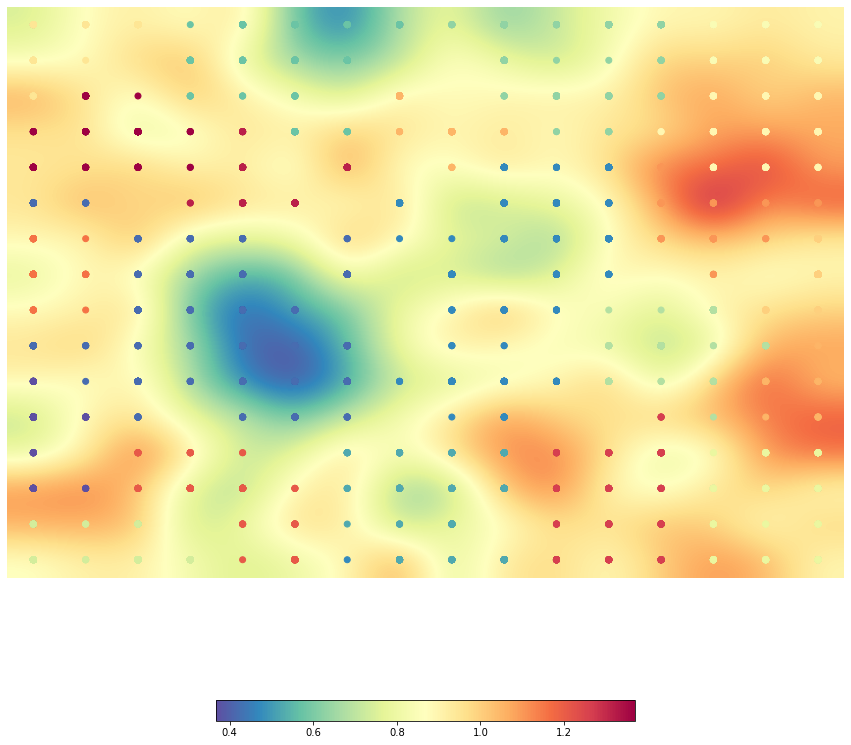



Clusters sorted by ascending order of neurons:
  [12  9 15 11  7  0 18 10 14  6 13 19  8 16 17  3  4  5  2  1]
Number of neurons per cluster:
  [ 5  6  6  7  7  7  9 10 10 11 11 11 12 12 13 15 16 16 36 36]
For cluster 0:
Category                                 Number                                   Percentage                              
World cinema                             169                                      25.0%                                   
Drama                                    160                                      23.67%                                  
Bollywood                                55                                       8.14%                                   
Musical                                  49                                       7.25%                                   
Crime Fiction                            21                                       3.11%                                   


For cluster 1:
Category              

In [ ]:
#20 clusters
algorithm = KMeans(n_clusters = 20)
som2.cluster(algorithm = algorithm)   #16x16

clusters2 = som2.clusters
print(clusters2)

som2.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

clusters_unique2 = np.unique(clusters2, return_index = True, return_counts = True)
clusters_sorted2 = np.argsort(clusters_unique2[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted2)
print("Number of neurons per cluster:\n ", clusters_unique2[2][clusters_sorted2])

for i in range(20):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters2,i, ubmus2), ubmus2 , indices2)
  print('\n')

[[20 20 20  3 14 14 14 14 14  0  0  0 10 10 10 10]
 [20 20 20  3 14 14 14 14  0  0  0  0 10 10 10 10]
 [20 20 17  3 14 14 14 19 19  0  0  0  0  6  6  6]
 [17 17 17 17 13 13 13 19 19 19  0  0  0  6  6  6]
 [17 17 17 17 13 13 13 24 19 24 24  5  5  6  6  6]
 [ 1  1 17  1  1  1 24 24 24 24 24  5  5  5 22 22]
 [ 1  1  1  1  1  1 15 24 15 24 24  5  5  5 22 22]
 [ 1  1  1  1  1  1 15 15 15 15 24 24  5  7  7  7]
 [ 1  1  1  1  1  1  1 15 15 24 24 24  7  7  7  7]
 [ 1  1 23  1  1  1  1  1 18 18 18 24 24  7  9  9]
 [23 23 23  1  1  1  1 18 18 18 18 18 24  9  9  9]
 [23 23 23 23  1  1  1 24 18 18 18  4  4  4  9  9]
 [16 23 23  8  8  1  2  2  2  2 21  4  4  4 12 12]
 [16 16  8  8  8  8  2  2  2  2 21 21  4 12 12 12]
 [11 11 11  8  8  8  2  2  2  2 21 21 21 12 12 12]
 [11 11 11 11  8  8 14  2  2  2 21 21 21 12 12 12]]


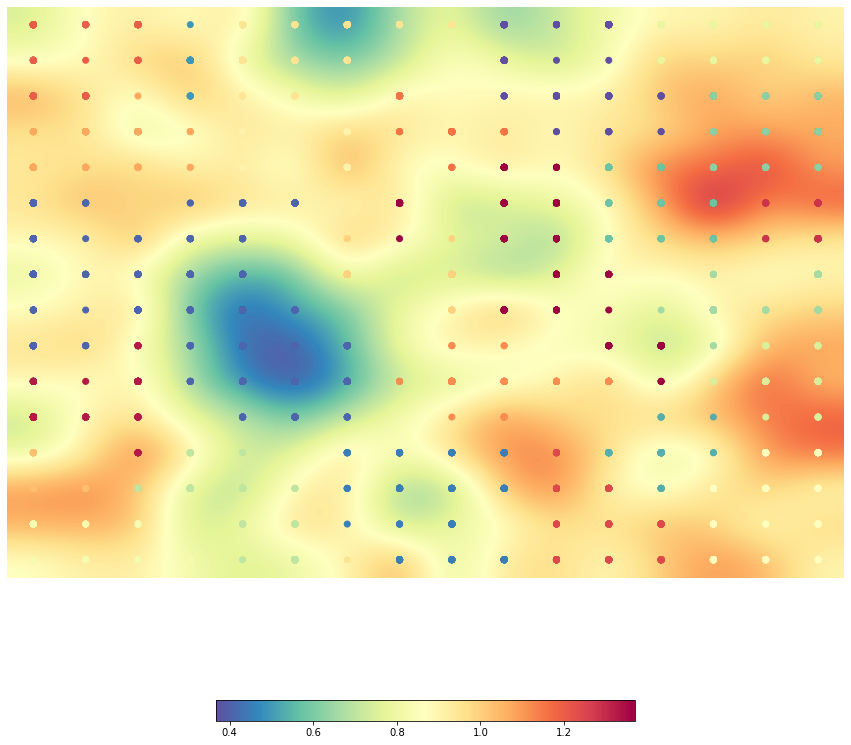



Clusters sorted by ascending order of neurons:
  [16  3 22 13 19  4 11  9 10 15 20  7  6  5 21 23 17 18  8 12 14  0  2 24
  1]
Number of neurons per cluster:
  [ 3  3  4  6  6  7  7  7  8  8  8  8  9  9  9 10 10 11 11 11 13 14 15 20
 39]
For cluster 0:
Category                                 Number                                   Percentage                              
Action                                   212                                      34.42%                                  
Drama                                    68                                       11.04%                                  
Adventure                                67                                       10.88%                                  
Crime Fiction                            40                                       6.49%                                   
Science Fiction                          20                                       3.25%                                   


For c

In [ ]:
#25 clusters
algorithm = KMeans(n_clusters = 25)
som2.cluster(algorithm = algorithm)   #16x16

clusters2 = som2.clusters
print(clusters2)

som2.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

clusters_unique2 = np.unique(clusters2, return_index = True, return_counts = True)
clusters_sorted2 = np.argsort(clusters_unique2[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted2)
print("Number of neurons per cluster:\n ", clusters_unique2[2][clusters_sorted2])

for i in range(25):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters2,i, ubmus2), ubmus2 , indices2)
  print('\n')

#25 clusters
algorithm = KMeans(n_clusters = 25)
som2.cluster(algorithm = algorithm)   #16x16

[[13 13 13  6  6  6  6  6  4  4  4  4  4 15 15 15]
 [13 13  3  3  6  6  6  6  4  4  4  4  4 15 15 15]
 [13 24 24  3  6  6  6 16 16  4 14 14 14 14 27 27]
 [24 24 24 24 19  6  6 16 16 16 14 14 14 14 27 27]
 [24 24 24 19 19 19  0  0 16  8  8  8 10 10 10 10]
 [ 2  2 11 19 19 19  0  0  0  8  8  8 10 10 10 10]
 [28 28  2  2  2 19  2  0 23  8  8  8  8  8 21 21]
 [28 28  2  2  2  2  2 23 23 23  8  8  8 21 21 21]
 [28 28 28  2  2  2  2 23 23 23  8  7  7 21 21 21]
 [ 2 28 28  2  2  2  2  2 29 29 29  7  7  7 25 25]
 [11 11  2  2  2  2  2 29 29 29 29  7  7 25 25 25]
 [11 11 11  2  2  2  2  8 29 29 29  7 18  7 25 16]
 [11 11 20 20 20  2  5  5  5 22 22 18 18 18  1  1]
 [11 11 20 20 20 20  5  5  5 22 22 26 18 18  1  1]
 [ 9  9  9 20 20 12 12  5  5  5 26 26 26 17 17 17]
 [ 9  9  9  9 12 12 12  5  5  5 26 26 26 17 17 17]]


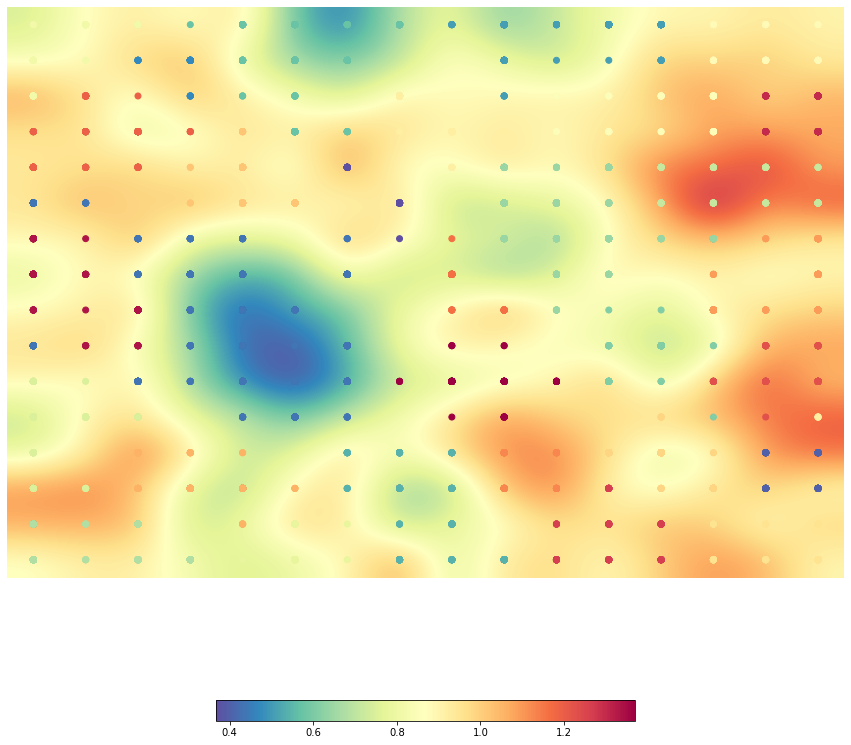



Clusters sorted by ascending order of neurons:
  [ 3  1 27 22 12  0 17 25 13 15 18 16  9 23 26 19 21 14 10 20  7 24 28 11
 29  4  5  6  8  2]
Number of neurons per cluster:
  [ 3  4  4  4  5  6  6  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10
 10 11 12 14 16 31]
For cluster 0:
Category                                 Number                                   Percentage                              
Silent film                              44                                       43.56%                                  
Family Film                              24                                       23.76%                                  
Adventure                                9                                        8.91%                                   
Fantasy                                  4                                        3.96%                                   
Musical                                  3                                        2.97%             

In [ ]:
#30 clusters
algorithm = KMeans(n_clusters = 30)
som2.cluster(algorithm = algorithm)   #16x16

clusters2 = som2.clusters
print(clusters2)

som2.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

clusters_unique2 = np.unique(clusters2, return_index = True, return_counts = True)
clusters_sorted2 = np.argsort(clusters_unique2[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted2)
print("Number of neurons per cluster:\n ", clusters_unique2[2][clusters_sorted2])

for i in range(30):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters2,i, ubmus2), ubmus2 , indices2)
  print('\n')

για SOM 25x25 : 

In [ ]:
som3 = joblib.load('som_25_25.pkl')

[[22 22 22 22 22 14 14 14 14  0  0  0  0  0  0  0  8  8  8  8  8 24 24 24
  24]
 [22 22 22 22 22 14 14 14 14  0  0  0  0  0  0  0  8  8  8  8  8 24 24 24
  24]
 [22 22 22 22 14 14 14 14 14 14  0  0  0  0  0  8  8  8  8  8  8 24 24 24
  24]
 [22 22 22 22 14 14 14 14 14 14  0  0  0  0 15 15  8  8  8  8  8 24 24 24
  24]
 [17 17 17 17 14 14 14 14 14 14 13 15 15 15 15 15 15  8  8  8  8 20 20 24
  24]
 [17 17 17  6  6 14 14 13 13 13 13 15 15 15 15 15 15 15 15  8 20 20 20 24
  24]
 [17 17  6  6  6 13 13 13 13 13 13 15 15 15 15 15 15 15 15 20 20 20 20 20
  24]
 [17 17 17  6  6 13 13 13 13 13 13 15 15 15 15 15 15 15 20 20 20 20 20 20
  24]
 [17 17 17  6  6  6 13 18 18 18  7  7  7  3 15  3 15 15 15 20 20 20 20 20
   6]
 [11 17 17 17  6 18 18 18 18 18  7  7  7  3  3  3 15  1  1 19 20 20 20  6
   6]
 [11 11 17 17 11 18 18 18 18 18  7  7  7  3  3  3 19 19 19 19 19 20  6  6
   6]
 [11 11 11 11 11  5 18 18 18 18  7  7  7  3  3  3 19 19 19 19 19  1  6  6
   6]
 [11 11 11 11 11  5  5  5  5  5  7  7  7

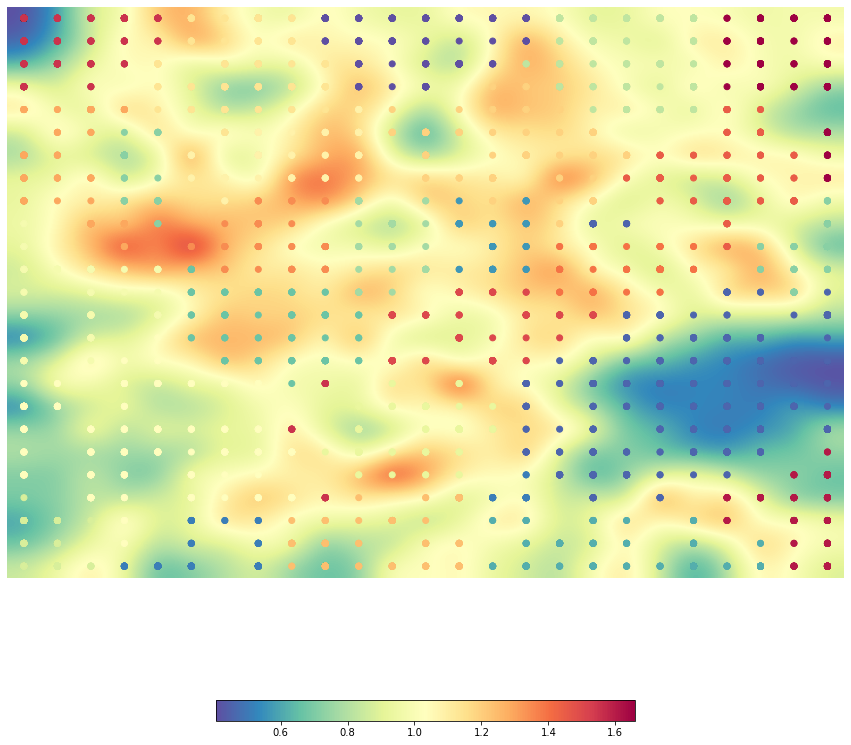





Clusters sorted by ascending order of neurons:
  [ 3  9  7 19  2 18 23 13 17  6 24 21 16  0 10  5  4 20 22  8 11 14 15 12
  1]
Number of neurons per cluster:
  [11 11 15 16 17 17 17 18 20 21 22 22 22 23 24 24 25 25 25 26 26 28 36 56
 78]


For cluster 0:
Category                                 Number                                   Percentage                              
Thriller                                 230                                      26.65%                                  
Horror                                   130                                      15.06%                                  
Psychological thriller                   43                                       4.98%                                   
Science Fiction                          43                                       4.98%                                   
Action                                   33                                       3.82%                                   


F

In [ ]:
#clusters = 25
algorithm = KMeans(n_clusters = 25)
som3.cluster(algorithm = algorithm)   #25x25

clusters3 = som3.clusters
print(clusters3)

som3.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

print('\n')
clusters_unique3 = np.unique(clusters3, return_index = True, return_counts = True)
clusters_sorted3 = np.argsort(clusters_unique3[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted3)
print("Number of neurons per cluster:\n ", clusters_unique3[2][clusters_sorted3])
print('\n')

for i in range(25):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters3,i, ubmus3), ubmus3 , indices3)
  print('\n')

[[23 23 23 23 23 23 14 14 14 22 22 22 22 22 28 28 21 21 21 21 21  6  6  6
   6]
 [23 23 23 23 23 14 14 14 14 22 22 22 28 28 28 28 21 21 21 21 21  6  6  6
   6]
 [23 23 23 23 23 14 14 14 14 14 22 22 28 28 28 18 18 21 21 21 21  6  6  6
  28]
 [23 23 10 23 14 14 14 14 14 14 22 28 28 28 18 18 18 21 21 21 11 11 11 11
  11]
 [10 10 10 10 14 14 14 14 14 14  1  1  1  1 18 18 18 21 21 21 11 11 11 11
  11]
 [10 10 10 10 14 14 14 12 12 12  1  1  1  1 18 18 21 21 21 21 11 11 11 11
  11]
 [10 10 10 13 13 12 12 12 12 12  1  1  1  1  1  1 21 21  1 19 19 19 11 11
  11]
 [10 10 10 13 13 12 12 12 12 12  1  1  1  1  8  1 15 19 19 19 19 19 19 11
  11]
 [10 10 26 26 27 27 12 12 27 27 27 27  1 15 15 15 15  1  1 19 19 19 19 13
  13]
 [20 26 26 26 26 16 27 27 27 27 27 27 27 15 15 15 15  1  1  4 19 19 19 13
  13]
 [20 20 26 26 16 16 16 27 27 27 27 27 15 15 15 15 15 15  4  4  4 19 13 13
  13]
 [20 20 20 20 16 16 16  3 27 27 27 27 15 15 15 15 15 15  4  4  4  4 13 13
  13]
 [20 20 20 20 16 16 16  3  3  3  3 17 17

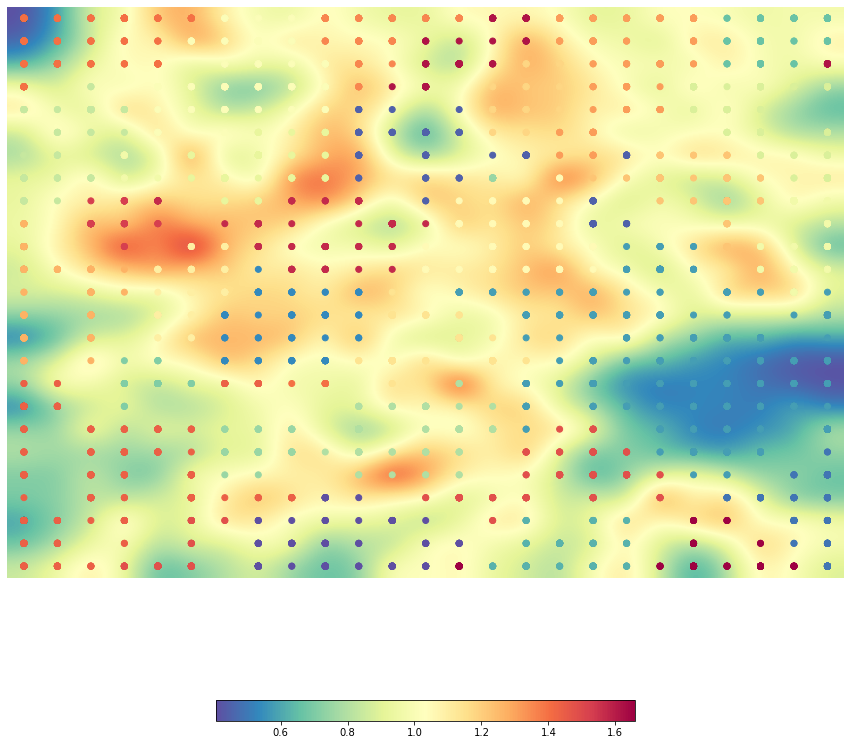





Clusters sorted by ascending order of neurons:
  [26 18  7 22  8  6 28 29 16  5 12 13  2 19 10 17  3 11 15 23 20 27  0  9
  1 21 14 25 24  4]
Number of neurons per cluster:
  [ 8 10 10 11 11 11 13 13 14 14 15 15 15 17 17 18 19 20 21 22 22 22 23 23
 25 26 27 31 48 84]


For cluster 0:
Category                                 Number                                   Percentage                              
Comedy                                   180                                      21.61%                                  
Romance Film                             170                                      20.41%                                  
Romantic comedy                          151                                      18.13%                                  
Drama                                    38                                       4.56%                                   
Indie                                    33                                       3.96%         

In [ ]:
#clusters = 30
algorithm = KMeans(n_clusters = 30)
som3.cluster(algorithm = algorithm)   #25x25

clusters3 = som3.clusters
print(clusters3)

som3.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

print('\n')
clusters_unique3 = np.unique(clusters3, return_index = True, return_counts = True)
clusters_sorted3 = np.argsort(clusters_unique3[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted3)
print("Number of neurons per cluster:\n ", clusters_unique3[2][clusters_sorted3])
print('\n')

for i in range(30):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters3,i, ubmus3), ubmus3 , indices3)
  print('\n')

[[ 4  4  4  4  4 22 22 22 22 22 13 13 13 12 12 28 28 28 28 28 14 14 14 14
  12]
 [ 4  4  4  4  4 22 22 22 22 13 13 13 12 12 12 28 28 28 28 28 14 14 14 14
  12]
 [ 4  4  4  4  4 30 30 30 30 13 13 13 12 12 12 28 28 28 28 28 28 14 14  9
  12]
 [ 4  4 29  4  4 30 30 30 30 30 13 12 12 12  8  8  8 28 28 28  9  9  9  9
   9]
 [29 29 29 29 30 30 30 30 30 30 30 21 21 21  8  8  8 34 34 28  9  9  9  9
   9]
 [32 29 29 24 30 30 30 16 16 16 21 21 21 21  8  8 34 34 34  0  9  9  9  9
   9]
 [32 32 24 24 24 16 16 16 16 16 21 21 21 21 34 34 34 34  0  0  0 23  9  9
   9]
 [32 32 24 24 24 16 16 16 16 16 21 21 21 21 21 34 34  0  0  0  0 23 23  9
   9]
 [32 32 32 24 24 24 16 16  2  2 31 31 31 31 21 21 21 21  0  0 23 23 23 23
  24]
 [10 32 32 24 24  2  2  2  2  2 31 31 31 31 31 18 21 21 21 18 23 23 23 24
  24]
 [10 10 32 24 10 20  2  2  2  2  2 31 31 31 31 18 18 18 18 18 18 23 23 24
  24]
 [10 10 10 10 10 20 20 20  2  2  2 31 31 31 31 18 18 18 18 18 18  7 24 24
  24]
 [10 10 10 10 10 20 20 20 20 20 17 17 31

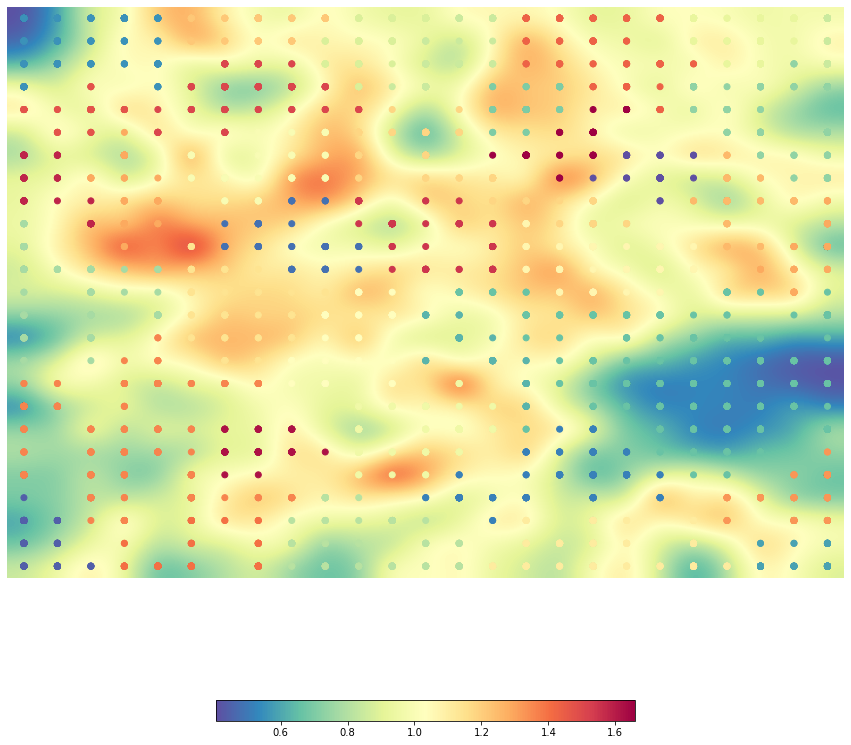





Clusters sorted by ascending order of neurons:
  [ 5 29  8 22  0  1 14 13 32 33 34  6 23 25 12 27  2 16 17 31 18 30  4 20
 28 15  9 11 24 19 21  3 10 26  7]
Number of neurons per cluster:
  [ 6  7  8  9 10 10 10 10 11 11 11 12 12 13 14 14 15 15 17 18 18 19 19 19
 20 21 21 21 22 22 23 23 26 47 71]


For cluster 0:
Category                                 Number                                   Percentage                              
Crime Fiction                            42                                       25.93%                                  
Action                                   39                                       24.07%                                  
Drama                                    30                                       18.52%                                  
Comedy film                              9                                        5.56%                                   
Action/Adventure                         7                        

In [ ]:
#clusters = 35
algorithm = KMeans(n_clusters = 35)
som3.cluster(algorithm = algorithm)   #25x25

clusters3 = som3.clusters
print(clusters3)

som3.view_umatrix(colorbar = True, bestmatches = True, figsize=(15, 15))
print('\n')

print('\n')
clusters_unique3 = np.unique(clusters3, return_index = True, return_counts = True)
clusters_sorted3 = np.argsort(clusters_unique3[2])
print("Clusters sorted by ascending order of neurons:\n ", clusters_sorted3)
print("Number of neurons per cluster:\n ", clusters_unique3[2][clusters_sorted3])
print('\n')


for i in range(35):
  print("For cluster "+str(i)+":")
  neurons_movies_report(print_cluster_neurons_movies_report(clusters3,i, ubmus3), ubmus3 , indices3)
  print('\n')

In [ ]:
n=1;
while n>0:
  n=1;

KeyboardInterrupt: ignored

Παρατηρούμε πως κάθε σε πολλά cluster αντιστοιχίζονται σε ξεχωριστή θεματική ενότητα (δηλαδή μία κατηγορία υπερτερεί των υπολοίπων). Αυξάνοντας τον αριθμό των clusters προκύπτουν περισσότερες και πιο πλούσιες οικογένειες κατηγοριών.

Για τη βελτιστοποίηση του SOM μας ενδιαφέρουν τα εξής κριτήρια:

- Αν υπάρχουν πολλές κόκκινες περιοχές που δηλώνουν ότι η μέση απόστασή του  από τους γειτονικούς κόμβους είναι πολύ μεγάλη και δεν είναι clusters αλλά σύνορα αυτών,καταλαβαίνουμε ότι μπορούμε προσθέσουμε περισσότερους νευρώνες και ίσως να πετύχουμε καλύτερο αποτέλεσμα.
  
- Πρέπει σε κοντινά clusters σημασιολογικά κοντινές ταινίες πχ θέλουμε το comedy thriller και action thriller να είναι κοντά ενώ τα comedy thriller είναι μεταξύ των cluster των thriller και το action. Ιδανικά θέλουμε τα clusters comedy και drama να είναι αρκετά απομακρυσμένα μεταξύ τους καθώς δεν έχουν κοινή σημασιολογία. Γι αυτό καταληγουμε στο συμπερασμα οτι ο ιδανικός χάρτης είναι 25x25 .

Για το clustering που εφαρμόζουμε με αλγόριθμο συσταδοποίησης (π.χ. k-means) για να βρούμε ποιοι νευρώνες νικητές ανήκουν στο ίδιο cluster κάνουμε το εξής:

- Όσο μεγαλύτερος ο χάρτης τόσο μεγαλύτερο πρέπει να είναι το k του k-means και αυτό είναι λογικό γιατί θα έχει περισσότερους νευρώνες που θα πρέπει να ομαδοποιηθούν. Μικρό k δημιουργεί clusters που δείχνουν τις υπερομάδες ενώ μεγάλο k δημιουργεί clusters για κάθε υποομάδα. Πρέπει το k να μην είναι πολύ μεγάλο αλλά ούτε πολύ μικρό. Στη περίπτωσή μας, για k>25 δημιουργούνται πολλές υποομάδες με αποτέλεσμα να χάνουν τη συνοχή τους τα δύο επικρατέστερα είδη των δειγμάτων που είναι το Drama και το Comedy.

Άρα από τα παραπάνω ο καλύτερος SOM είναι ο 25 x 25, 100 epochs training και με clustering k= 25 στον k-means.


##Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Αρχικά, για στατιστικούς λόγους εντοποπίζουμε τις πιο δημοφιλείς κατηγορίες σε όλο το dataset.

In [ ]:
global_counter = Counter()
for cat_str in categories[:, 0]:
    global_counter.update(cat_str[1: -1].split('",  "'))

print('Most common categories in dataset:')
print(global_counter.most_common(5))

Most common categories in dataset:
[('Drama', 2256), ('Comedy', 1154), ('Thriller', 814), ('Romance Film', 754), ('Action', 701)]


και τώρα θα σχολιάσουμε το επιλεγμένο SOM (25x25 , 100 epochs , 25 clusters) :

##Τρεις τοπολογικές ιδιότητες του SOM
Παρατηρούμε πως τα clusters με το μεγαλύτερο αριθμό νευρώνων είναι 1, 12 και 15. Τα clusters αυτά έχουν ως δημοφιλέστερες κατηγορίες ταινιών Drama, Comedy και Action αντίστοιχα. Εξετάζοντας τα στατιστικά του dataset, προκύπτει πως οι δύο πρώτες κατηγορίες είναι όντως οι πιο δημοφιλείς. 

Συνεπώς συμπεραίνουμε πως δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας.

Τα clusters 1 και 22 βρίσκονται στις δύο άκρες της κύριας διαγωνίου και απέχουν τη μέγιστη δυνατή απόσταση. Οι πιο δημοφιλείς κατηγορίες τους είναι Drama και Comedy αντίστοιχα. Συνεπώς μεγάλη απόσταση στον χάρτη SOM συνοδεύεται από μεγάλη "θεματική" απόσταση. Όμοια κατάσταση επικρατεί και για τα ζευγάρια clusters 24 (Documentary) και 9 (Thriller), 2 (Romance) και 7 (Adventure).

Επομένως, καταλήγουμε στο συμπέρασμα πως μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη.

Αντίστοιχα, εύκολα παρατηρεί κανείς πως τα clusters 0 (Thriller), 14 (horror) και 15 (Action) σχηματίζουν μια γειτονιά στον χάρτη SOM. Το ίδιο μπορεί να ειπωθεί για τα ζευγάρια 5 (Family Film) και 12 (Comedy). 

Επομένως, καταλήγουμε στο συμπέρασμα πως κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη.

Απόλυτη τοπολογία δεν μπορεί να υπάρξει καθώς δεν υπάρχει απόλυτος ορισμός για τη κάθε κατηγορία και διότι πραγματοποιήσαμε μείωση της διαστατικότητας.

##Clusters χωρίς σαφή χαρακτηριστικά
Ενώ όλα τα υπόλοιπα clusters περιέχουν κάποια κυρίαρχη κατηγορία με ποσοστό εμφάνισης >38%, το cluster 12 έχει μέγιστο ποσοστό ~10%. Ταυτόχρονα δεν έχει σαφή ταυτότητα καθώς οι πιο δημοφιλείς του κατηγορίες είναι Comedy και Western.      

##Clusters που δεν έχουν τοπολογική συνάφεια με γύρω περιοχές
Δύο νευρώνες του cluster 1 είναι απομονωμένοι από το υπόλοιπο σύνολο (κάτω δεξιά γωνία), ενώ περικλείεται από τα clusters 15,20,19 που είναι άσχετα ως προς το είδος. 
##Επιπρόσθετες ενδιαφέρουσες παρατηρήσεις
Πολλά από τα clusters με μικρά ποσοστά(στα οποία ισοβαθμούν διαφορετικές κατηγορίες) έχουν συσχέτιση ως προς το είδος μεταξύ τους.

παρακάτω φαίνονται μερικά από αυτά:

|cluster| cat1  | cat2  | cat3  |   |
|---|---|---|---|---|
|5 | Family film | Children's/Family | Animation|
|7 | Adventure   | Action            |
|8 | Action | Thriler| Action/Adventure   |
|18  |Adventure| Fantasy| Science Fiction|
|19 | War film | Drama | Action |

Τέλος,αν και η επικρατέστερη κατηγορία είναι τα Drama,Comedy και υπερισχύουν σε πολλά cluster, το cluster 9 περιέχει ως επικρατέστερη την documentary, μια όχι και τόσο συχνή κατηγορία.